In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import math

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Configuration Hyper-parameters
num_epochs = 20
batch_size = 32
learning_rate = 0.1

In [6]:
#load data
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [8]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

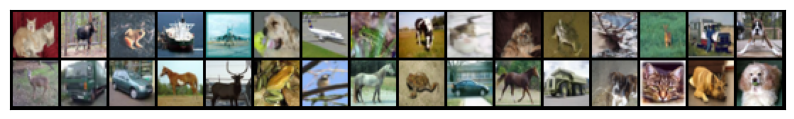

In [9]:
show_batch(train_loader)

In [10]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [11]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 32, 16, 16])


In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [13]:
model = ConvNet().to(device)
model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 10])
out[0]: tensor([ 0.0530,  0.0170, -0.0046, -0.0037,  0.0235,  0.0423, -0.0140,  0.0338,
        -0.0100,  0.0254], device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
#Train
'''
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
'''

def accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

start_train = time.time()
for epoch in range(num_epochs):
    train_losses = []
    start_epoch = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    end_epoch = time.time()
    print (f'Epoch [{epoch}/{num_epochs}], Loss: {torch.stack(train_losses).mean().item():.4f}, Acc: {accuracy(train_loader, model)}, Time: {(end_epoch - start_epoch)}')
    train_losses.clear()
end_train = time.time()
print(f'Training time: {end_train - start_train}')
print('Finished Training')

Epoch [0/20], Loss: 2.2864, Acc: 0.20005999505519867, Time: 8.30469036102295
Epoch [1/20], Loss: 2.0390, Acc: 0.35211998224258423, Time: 7.939760208129883
Epoch [2/20], Loss: 1.5591, Acc: 0.5016599893569946, Time: 7.7968244552612305
Epoch [3/20], Loss: 1.2130, Acc: 0.6168400049209595, Time: 7.634892702102661
Epoch [4/20], Loss: 0.9374, Acc: 0.6335799694061279, Time: 8.30857253074646
Epoch [5/20], Loss: 0.7334, Acc: 0.7723000049591064, Time: 9.146259546279907
Epoch [6/20], Loss: 0.5651, Acc: 0.8251399993896484, Time: 8.201479196548462
Epoch [7/20], Loss: 0.4193, Acc: 0.9181999564170837, Time: 8.13809061050415
Epoch [8/20], Loss: 0.3154, Acc: 0.8940399885177612, Time: 8.115527391433716
Epoch [9/20], Loss: 0.2431, Acc: 0.9412199854850769, Time: 7.988548278808594
Epoch [10/20], Loss: 0.1832, Acc: 0.9576199650764465, Time: 8.104170560836792
Epoch [11/20], Loss: 0.1557, Acc: 0.9514199495315552, Time: 8.464402437210083
Epoch [12/20], Loss: 0.1371, Acc: 0.9807599782943726, Time: 7.825716733932

In [16]:
print (f'Acc: {accuracy(test_loader, model)}')

Acc: 0.739799976348877


In [235]:
PATH = './cnn.pth'
#torch.save(model.state_dict(), PATH)